## Training on mfcc features extracted by pyAudioAnalysis 

### Extracting features using librosa

In [15]:
# standard 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libs for audio
from scipy.io import wavfile
from pyAudioAnalysis import ShortTermFeatures as aF
from pyAudioAnalysis import audioBasicIO as aIO 
import numpy as np 

# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.base import clone
import random

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import utils
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score


In [5]:
def extract_features_pyAu(file_name):
    fs, s = wavfile.read(file_name)
    win, step = 0.050, 0.050
    [f, fn] = aF.feature_extraction(s, fs, int(fs * win), 
                                int(fs * step))
     
    return f

In [6]:
# Read Data
df = pd.read_csv("D:/SUTD/ISTD/Term 6/cds/Project/FULL DATASET_edited.csv")
y = df['PHQ_Binary']
x = df['Participant_ID']


# Audio files with lots of static
prob = [300, 305, 306, 308, 315, 316, 343, 354, 362, 375, 378, 381, 382, 385, 387, 388, 390, 392, 393, 395, 408, 413, 421, 438, 473, 476, 479, 490, 492]

all_part_features = []

for index, audio_num in enumerate(x):
    if audio_num not in prob:
        try:
            fn = 'D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/{}_AUDIO_p.wav'.format(audio_num)
            print("Extracting for " + str(audio_num))
            f = extract_features_pyAu(fn)
            print("Extracted!")
            features = []
            for feature in f:
                summation = 0
                for value in feature:
                    summation += value
                mean = summation/len(feature)
                #print(mean)
                features.append(mean)
            all_part_features.append(features)
        except Exception as e:
            print(e)

np.save("X_audio_pyAu_68_mean.npy",np.asarray(all_part_features))
      

# featuresdf = pd.DataFrame(features,columns = ['Participant_ID','feature','PHQ8_Binary'])
# featuresdf.to_csv('pyAu_mfcc_feature.csv')

Extracting for 301
Extracted!
Extracting for 302
Extracted!
Extracting for 303
Extracted!
Extracting for 304
Extracted!
Extracting for 307
Extracted!
Extracting for 309
Extracted!
Extracting for 310
Extracted!
Extracting for 311
Extracted!
Extracting for 312
Extracted!
Extracting for 313
Extracted!
Extracting for 314
Extracted!
Extracting for 317
Extracted!
Extracting for 318
Extracted!
Extracting for 319
Extracted!
Extracting for 320
Extracted!
Extracting for 321
Extracted!
Extracting for 322
Extracted!
Extracting for 323
Extracted!
Extracting for 324
Extracted!
Extracting for 325
Extracted!
Extracting for 326
Extracted!
Extracting for 327
Extracted!
Extracting for 328
Extracted!
Extracting for 329
Extracted!
Extracting for 330
Extracted!
Extracting for 331
Extracted!
Extracting for 332
Extracted!
Extracting for 333
Extracted!
Extracting for 334
Extracted!
Extracting for 335
Extracted!
Extracting for 336
Extracted!
Extracting for 337
Extracted!
Extracting for 338
Extracted!
Extracting

### Training

#### Read data

In [7]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

data = pd.read_csv("pyAu_mfcc_feature.csv")
#print(np.array(data['feature']))
X = np.load("X_audio_pyAu_68_mean.npy")
Y = data['PHQ8_Binary'].values
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE)
print(y_train.shape)
print(X_train.shape)

(106,)
(106, 68)


#### Evaluation

In [8]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

In [9]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

#### K cross

In [10]:
def k_cross(input_model, X=X_train, y=y_train, k=4, n=3, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
                
        model = clone(input_model) # prevents incremental fitting
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

### Models implementation

#### Gaussian Naive Bayes 

f1 mean score: 0.3441516837995166
recall mean score: 0.36923076923076925
[0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1
 0 0 0 1 0 0 1 1 1]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5973630831643002
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        29
           1       0.50      0.47      0.48        17

    accuracy                           0.63        46
   macro avg       0.60      0.60      0.60        46
weighted avg       0.63      0.63      0.63        46

Confusion Matrix: 
 [[21  8]
 [ 9  8]]


GaussianNB()

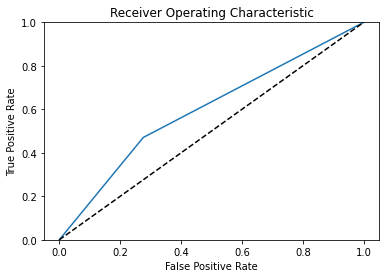

In [16]:
nb_model = GaussianNB()

f1_scores, recall_scores = k_cross(nb_model)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

evaluate_model(nb_model)

#### Logistic Regression

best scores: f1 = 0.28472783308309624, recall = 0.27350172975172976
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5243407707910751
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        29
           1       0.50      0.12      0.19        17

    accuracy                           0.63        46
   macro avg       0.57      0.52      0.48        46
weighted avg       0.59      0.63      0.55        46

Confusion Matrix: 
 [[27  2]
 [15  2]]


LogisticRegression(C=100000, n_jobs=3)

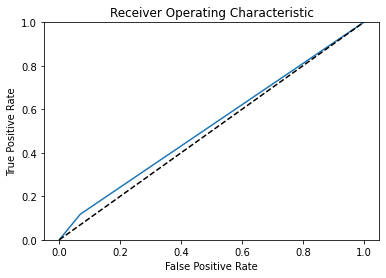

In [17]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_logreg_f1_model = find_best_logreg_model(6)
evaluate_model(best_logreg_f1_model)

#### Decision Tree

best scores: f1 = 0.33221022828220964, recall = 0.3165420227920228
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5537525354969574
              precision    recall  f1-score   support

           0       0.66      0.93      0.77        29
           1       0.60      0.18      0.27        17

    accuracy                           0.65        46
   macro avg       0.63      0.55      0.52        46
weighted avg       0.64      0.65      0.59        46

Confusion Matrix: 
 [[27  2]
 [14  3]]


DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=42)

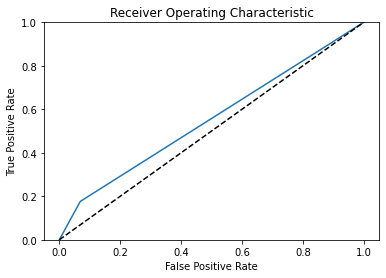

In [18]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                best_f1 = f1
                best_recall = recall
                best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_tree_f1_model = find_best_tree_model(20, 30)
evaluate_model(best_tree_f1_model)

#### Random Forest

best scores: f1 = 0.23144098548510314, recall = 0.19235602360602358
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5070993914807302
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        29
           1       0.40      0.12      0.18        17

    accuracy                           0.61        46
   macro avg       0.52      0.51      0.46        46
weighted avg       0.55      0.61      0.54        46

Confusion Matrix: 
 [[26  3]
 [15  2]]


RandomForestClassifier(n_estimators=7, random_state=42)

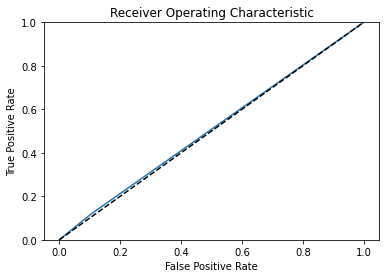

In [19]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_forest_f1_model = find_best_forest_model(30)
evaluate_model(best_forest_f1_model)

#### SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
Fitting 10 folds for each of 18 candidates, totalling 180

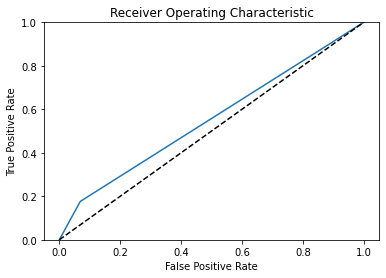

In [20]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")